# Stock Price Prediction - Data Exploration

This notebook explores the stock data and demonstrates the preprocessing pipeline before model training.

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import config
from data.data_loader import StockDataLoader
from data.preprocessor import StockPreprocessor
from utils.visualization import StockVisualization

# Initialize visualization object
viz = StockVisualization()

plt.style.use('seaborn-v0_8')
%matplotlib inline

## 1. Data Loading and Basic Information

In [2]:
# Load stock data
loader = StockDataLoader(symbols=config.stocks, period=config.data_period)
data = loader.get_combined_data()

print(f"Dataset shape: {data.shape}")
print(f"Date range: {data.index.min()} to {data.index.max()}")
print(f"Symbols: {data['symbol'].unique()}")
print(f"\nColumns: {list(data.columns)}")

Fetching data for NVDA
Fetching data for AAPL
Fetching data for MSFT
Fetching data for GOOGL
Fetching data for TSLA
Fetching data for AMZN
Fetching data for META
Fetching data for NFLX
Fetching data for COST
Fetching data for MELI
Fetching data for SBUX
Fetching data for ABNB
Fetching data for PYPL
Fetching data for KO
Fetching data for ADBE
Fetching data for WMT
Fetching data for V
Fetching data for MCD
Fetching data for NKE
Successfully loaded data for 19 symbols
Dataset shape: (46433, 8)
Date range: 0 to 46432
Symbols: ['NVDA' 'AAPL' 'MSFT' 'GOOGL' 'TSLA' 'AMZN' 'META' 'NFLX' 'COST' 'MELI'
 'SBUX' 'ABNB' 'PYPL' 'KO' 'ADBE' 'WMT' 'V' 'MCD' 'NKE']

Columns: ['open', 'high', 'low', 'close', 'volume', 'dividends', 'stock splits', 'symbol']


In [3]:
# Basic statistics
data.describe()

,open,high,low,close,volume,dividends,stock splits
count,46433.000000,46433.000000,46433.000000,46433.000000,4.643300e+04,46433.000000,46433.000000
mean,204.686273,207.365650,201.904133,204.710311,5.085134e+07,0.004598,0.001529
std,281.380502,285.511523,276.819104,281.271768,1.226165e+08,0.104520,0.145197
min,0.508905,0.530535,0.505017,0.523973,1.049000e+05,0.000000,0.000000
25%,54.918179,55.465229,54.393762,54.908909,4.678800e+06,0.000000,0.000000
50%,120.059998,121.650002,118.500000,120.150002,1.211570e+07,0.000000,0.000000
75%,233.750000,236.713218,231.020004,234.211395,3.629700e+07,0.000000,0.000000
max,2645.219971,2645.219971,2582.000000,2613.629883,3.692928e+09,15.000000,20.000000


In [4]:
# Check for missing values
missing_data = data.isnull().sum()
print("Missing values per column:")
print(missing_data[missing_data > 0])

Missing values per column:
Series([], dtype: int64)


## 2. Stock Price Visualization

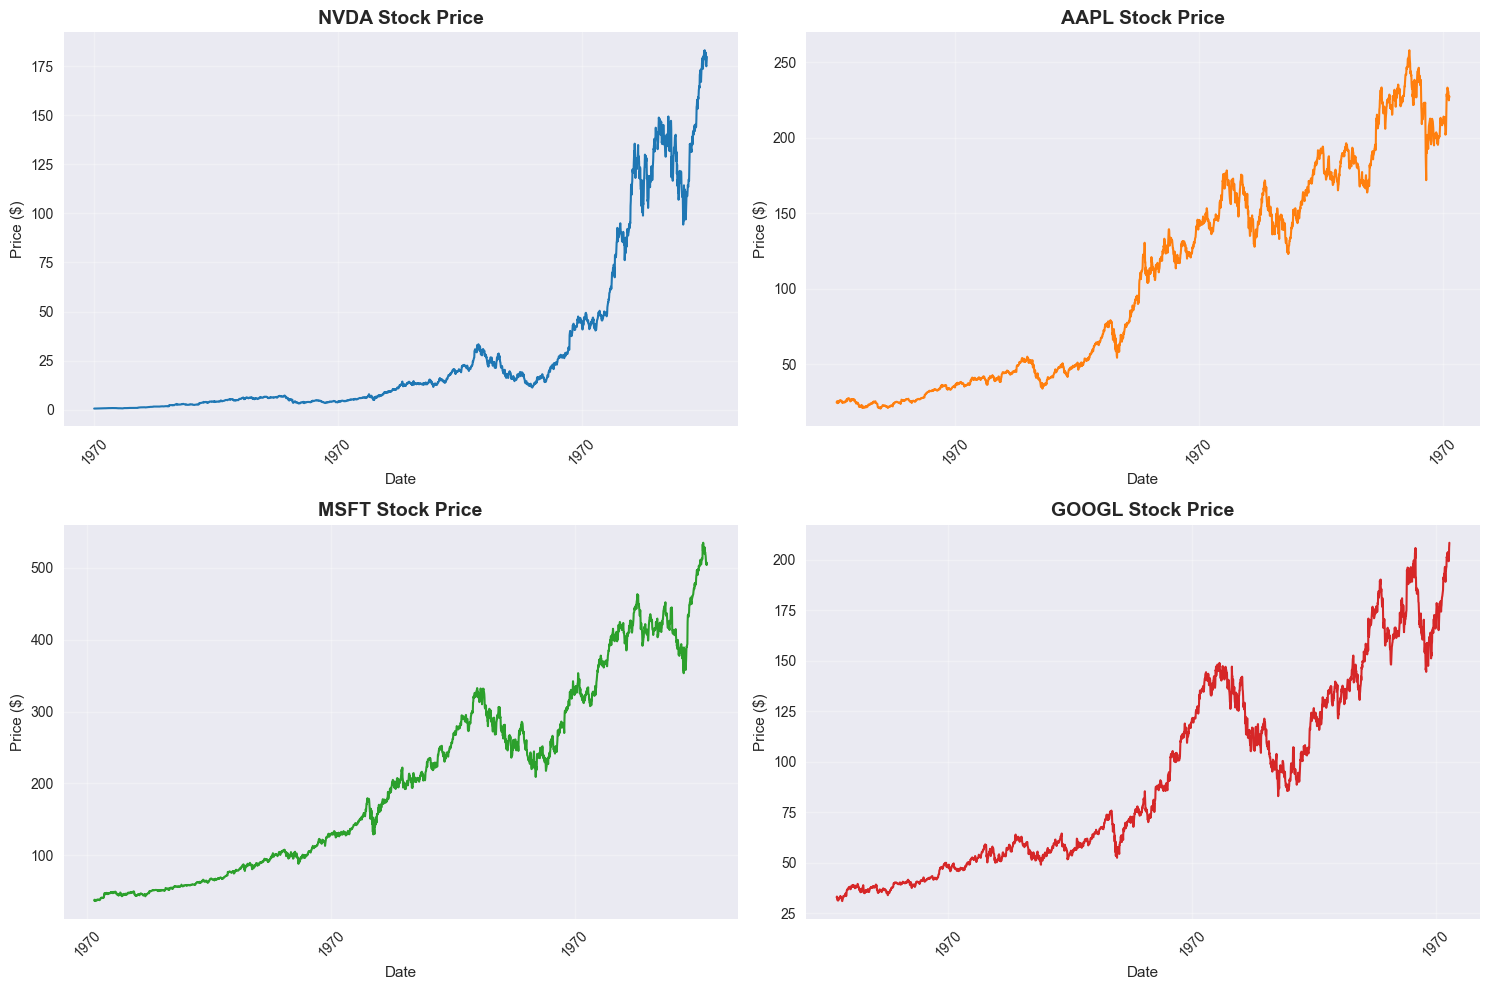

In [5]:
# Plot stock prices
viz.plot_stock_prices(data, symbols=config.stocks)

## 3. Data Analysis

In [6]:
# Data analysis
print(f"Dataset shape: {data.shape}")
print(f"Columns: {list(data.columns)}")

Dataset shape: (46433, 8)
Columns: ['open', 'high', 'low', 'close', 'volume', 'dividends', 'stock splits', 'symbol']


## 4. Feature Correlation Analysis

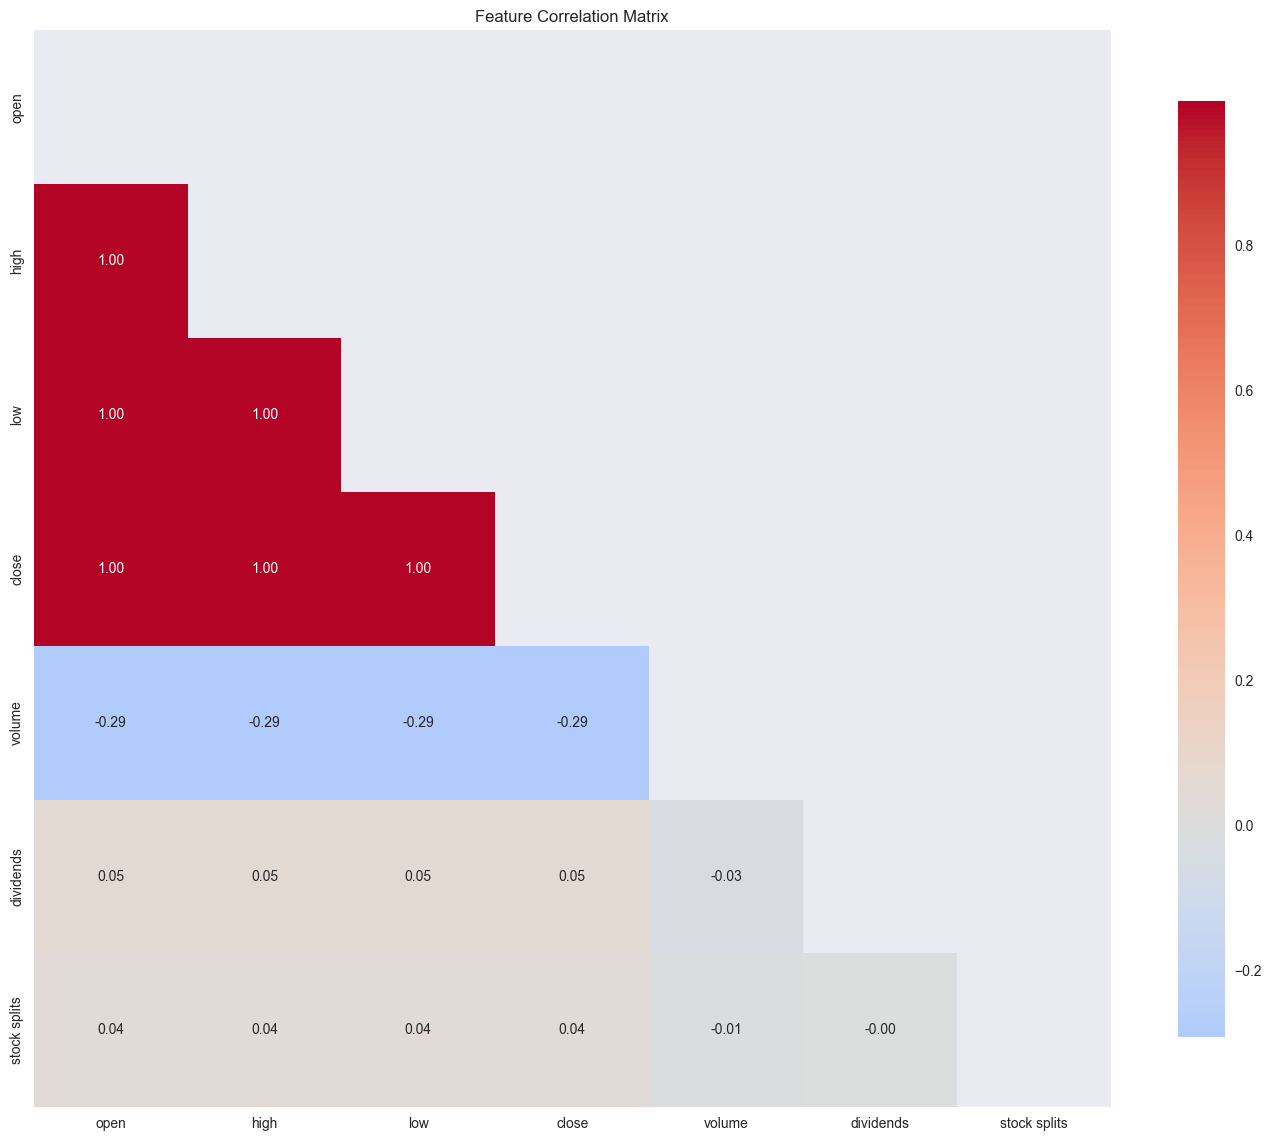

In [7]:
# Select numeric features for correlation analysis
single_data = data[data["symbol"] == config.stocks[0]].copy()
numeric_features = single_data.select_dtypes(include=[np.number]).columns
numeric_features = [col for col in numeric_features if col not in ["symbol"]]

# Plot correlation matrix
viz.plot_correlation_matrix(single_data[numeric_features], figsize=(14, 12))

## 5. Price Returns Analysis

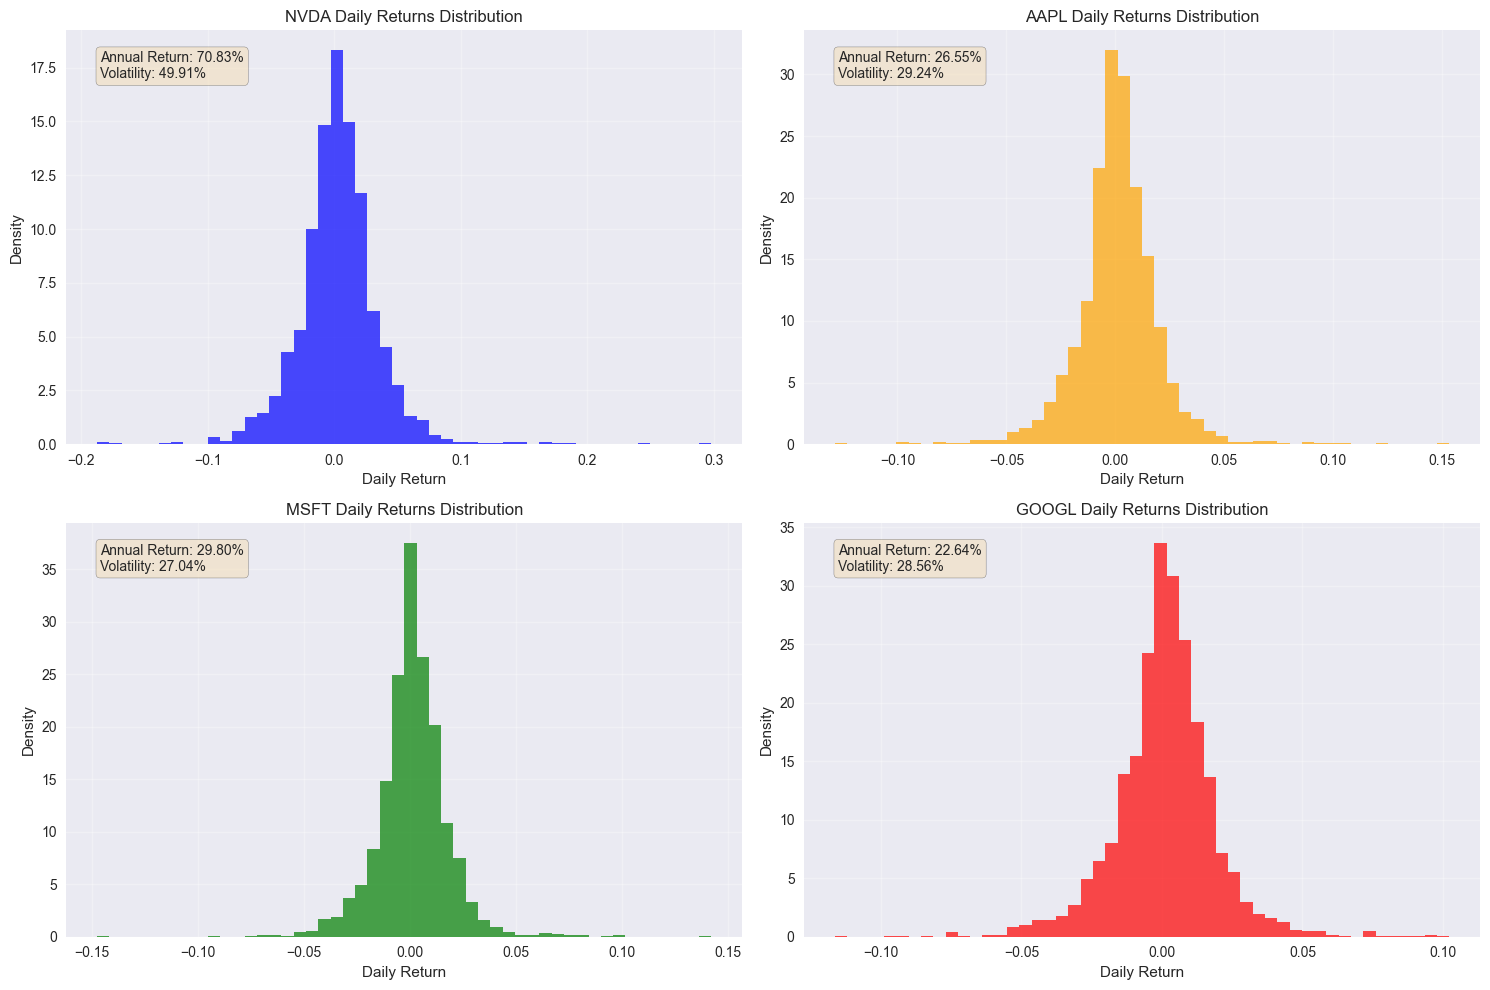

In [8]:
# Calculate daily returns for each stock
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

symbols = data["symbol"].unique()[:4]
colors = ["blue", "orange", "green", "red"]

for i, symbol in enumerate(symbols):
    symbol_data = data[data["symbol"] == symbol].copy()
    returns = symbol_data["close"].pct_change().dropna()

    axes[i].hist(returns, bins=50, alpha=0.7, color=colors[i], density=True)
    axes[i].set_title(f"{symbol} Daily Returns Distribution")
    axes[i].set_xlabel("Daily Return")
    axes[i].set_ylabel("Density")
    axes[i].grid(True, alpha=0.3)

    # Add statistics
    mean_return = returns.mean() * 252  # Annualized
    volatility = returns.std() * np.sqrt(252)  # Annualized
    axes[i].text(
        0.05,
        0.95,
        f"Annual Return: {mean_return:.2%}\nVolatility: {volatility:.2%}",
        transform=axes[i].transAxes,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
    )

plt.tight_layout()
plt.show()

## 6. Volatility Analysis

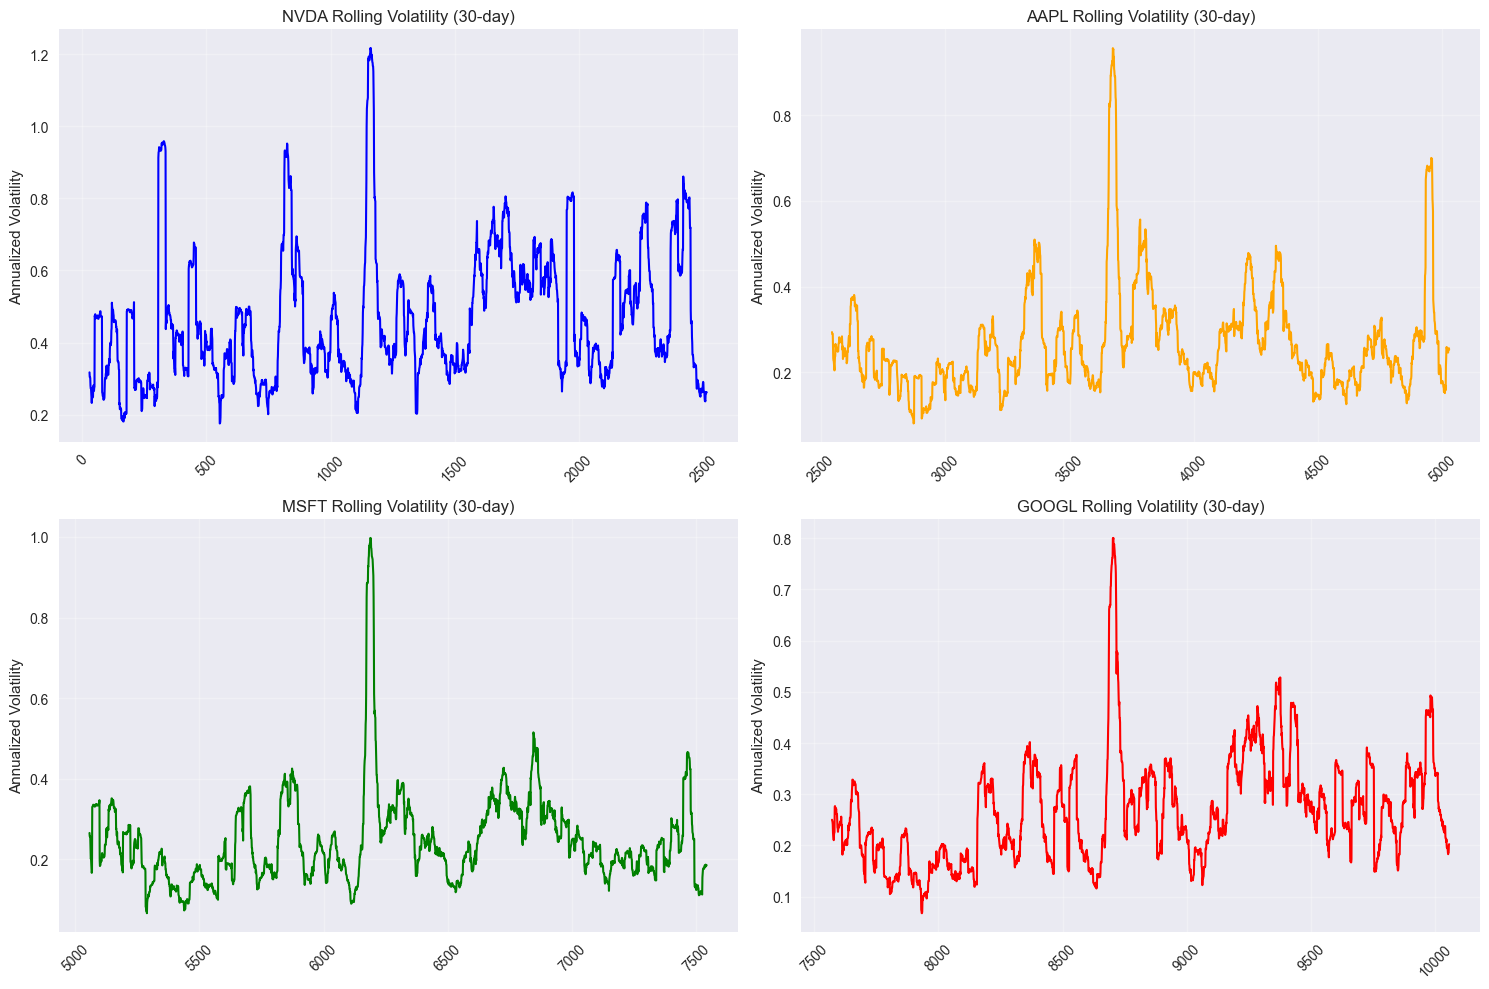

In [9]:
# Calculate rolling volatility
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, symbol in enumerate(symbols):
    symbol_data = data[data["symbol"] == symbol].copy()
    returns = symbol_data["close"].pct_change().dropna()

    # 30-day rolling volatility
    rolling_vol = returns.rolling(window=30).std() * np.sqrt(252)

    axes[i].plot(rolling_vol.index, rolling_vol, color=colors[i], linewidth=1.5)
    axes[i].set_title(f"{symbol} Rolling Volatility (30-day)")
    axes[i].set_ylabel("Annualized Volatility")
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

## 7. Data Preprocessing Pipeline

In [10]:
# Test the preprocessing pipeline
preprocessor = StockPreprocessor(sequence_length=config.sequence_length)

# Prepare data
data_dict = preprocessor.prepare_data(
    data, test_size=config.test_size, validation_size=config.validation_size
)

print(f"Input features: {data_dict['input_size']}")
print(f"Training sequences: {data_dict['X_train'].shape}")
print(f"Validation sequences: {data_dict['X_val'].shape}")
print(f"Test sequences: {data_dict['X_test'].shape}")
print(f"\nFeature columns ({len(data_dict['feature_columns'])}):")
for i, feature in enumerate(data_dict["feature_columns"][:10]):
    print(f"  {i}: {feature}")


Using stock-aware processing (stock-specific scaling + stock-aware batching)

Processing NVDA: 2514 data points
Created 2464 sequences with 6 features
Created 2464 sequences for NVDA

Processing AAPL: 2514 data points
Created 2464 sequences with 6 features
Created 2464 sequences for AAPL

Processing MSFT: 2514 data points
Created 2464 sequences with 6 features
Created 2464 sequences for MSFT

Processing GOOGL: 2514 data points
Created 2464 sequences with 6 features
Created 2464 sequences for GOOGL

Processing TSLA: 2514 data points
Created 2464 sequences with 6 features
Created 2464 sequences for TSLA

Processing AMZN: 2514 data points
Created 2464 sequences with 6 features
Created 2464 sequences for AMZN

Processing META: 2514 data points
Created 2464 sequences with 6 features
Created 2464 sequences for META

Processing NFLX: 2514 data points
Created 2464 sequences with 6 features
Created 2464 sequences for NFLX

Processing COST: 2514 data points
Created 2464 sequences with 6 feature

## 8. Sequence Analysis

Sample sequence shape: (50, 6)
Sample target: -0.6668


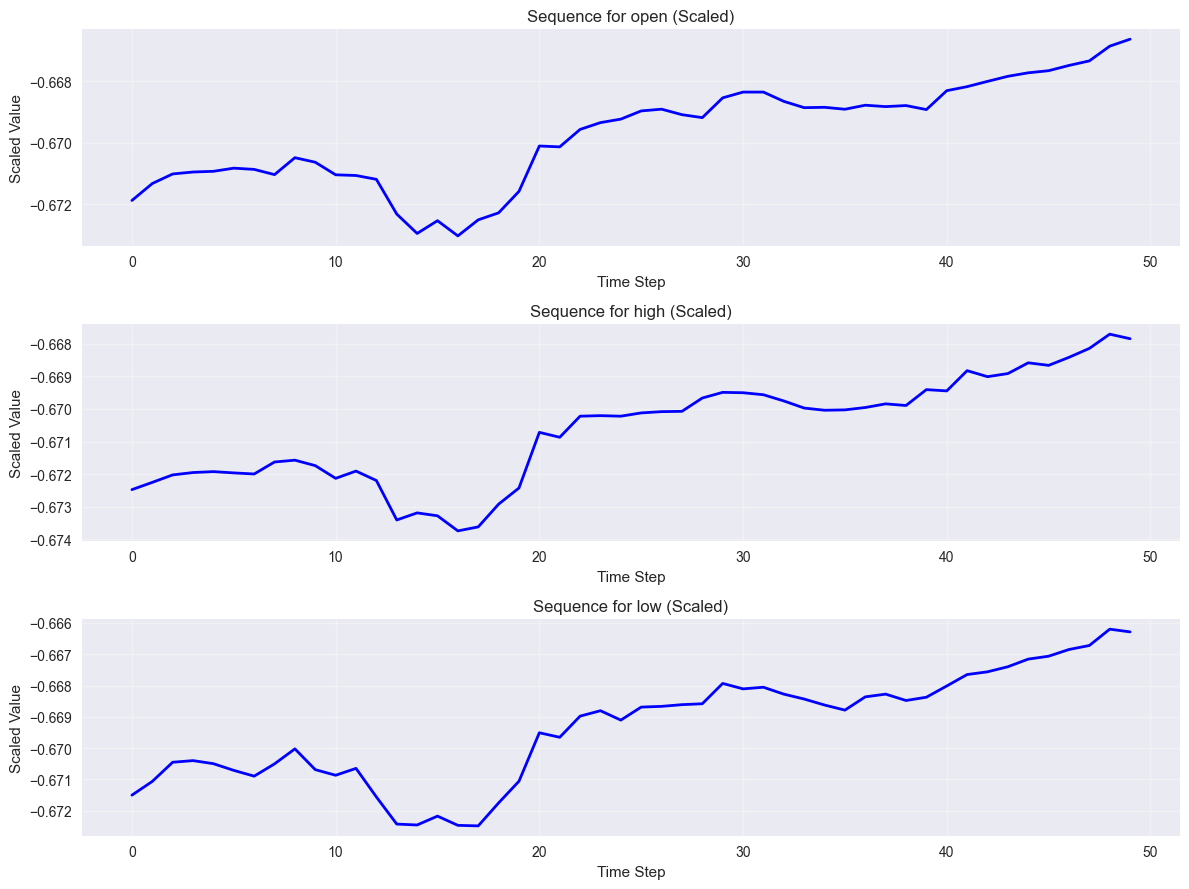

In [11]:
# Visualize a sample sequence
sample_idx = 100
sample_sequence = data_dict["X_train"][sample_idx]  # Shape: (sequence_length, features)
sample_target = data_dict["y_train"][sample_idx]

print(f"Sample sequence shape: {sample_sequence.shape}")
print(f"Sample target: {sample_target[0]:.4f}")

# Plot the sequence for key features
key_features = ["open", "high", "low"]
feature_indices = [
    data_dict["feature_columns"].index(feat)
    for feat in key_features
    if feat in data_dict["feature_columns"]
]

fig, axes = plt.subplots(
    len(feature_indices), 1, figsize=(12, 3 * len(feature_indices))
)
if len(feature_indices) == 1:
    axes = [axes]

for i, feat_idx in enumerate(feature_indices):
    feature_name = data_dict["feature_columns"][feat_idx]
    sequence_values = sample_sequence[:, feat_idx]

    axes[i].plot(range(len(sequence_values)), sequence_values, "b-", linewidth=2)
    axes[i].set_title(f"Sequence for {feature_name} (Scaled)")
    axes[i].set_xlabel("Time Step")
    axes[i].set_ylabel("Scaled Value")
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Target Distribution Analysis

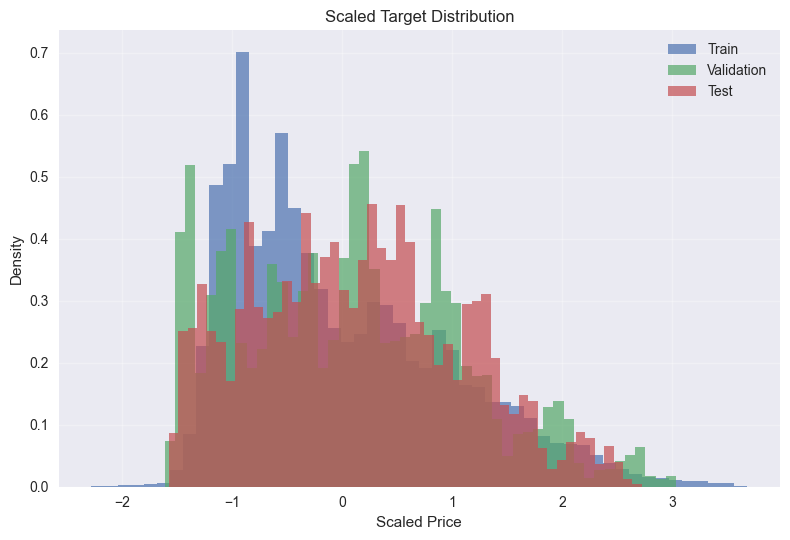

In [12]:
# Analyze target distribution
fig, ax = plt.subplots(1, 1)

# Original targets (scaled)
train_targets = data_dict["y_train"].flatten()
val_targets = data_dict["y_val"].flatten()
test_targets = data_dict["y_test"].flatten()

ax.hist(train_targets, bins=50, alpha=0.7, label="Train", density=True)
ax.hist(val_targets, bins=50, alpha=0.7, label="Validation", density=True)
ax.hist(test_targets, bins=50, alpha=0.7, label="Test", density=True)
ax.set_title("Scaled Target Distribution")
ax.set_xlabel("Scaled Price")
ax.set_ylabel("Density")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()